# Imports

In [38]:
import numpy as np
import pandas as pd

In [39]:
import re
from string import punctuation
import emoji

In [40]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    MultiHeadAttention,
    LayerNormalization,
    Dropout,
    GlobalAveragePooling1D,
    Flatten,
)

In [42]:
import matplotlib.pyplot as plt

In [43]:
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Vars definition

In [44]:
n_gram = 4
window_size = 5
percent_sample = 0.01
random_state=42

In [45]:
stop_words = set(stopwords.words("english"))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Data preparation

## Initial clean

In [46]:
df = pd.read_csv("data/data.csv")
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
...,...,...,...,...,...,...,...
24108,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,MSI Laptop is high performance and the best. c...
24109,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,Excellent performance best laptop.
24110,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,4,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...,4.4,7,2,3,Nice,The product does not support facial recognitio...


In [47]:
df_review = df[["review"]]
df_review

,review
0,"Loved it, it's my first MacBook that I earned ..."
1,Battery lasted longer than my first relationsh...
2,Such a great deal.. very happy with the perfor...
3,"Awesome build quality and very good display, b..."
4,When i ordered and came to know about seller r...
...,...
24108,MSI Laptop is high performance and the best. c...
24109,Excellent performance best laptop.
24110,Decent battery life. Exceptional build quality...
24111,The product does not support facial recognitio...


In [48]:
def clean_text_dataframe(
    df_i: pd.DataFrame,
    columns: list[str] | None = None,
    keep_apostrophe: bool = True,
    min_words: int = n_gram,
) -> pd.DataFrame:
    """
    Очищает текст и удаляет строки с малым количеством слов

    Params:
        df (pd.DataFrame): Исходный DataFrame
        columns (list[str]|None): Столбцы для обработки (None = все строковые)
        keep_apostrophe (bool): Сохранять апострофы (по умолчанию True)
        min_words (int): Минимальное количество слов для сохранения строки

    Return:
        pd.DataFrame: Очищенная и отфильтрованная копия DataFrame
    """
    df_clean = df_i.copy()

    # Определение целевых столбцов
    if columns is None:
        columns = df_clean.select_dtypes(include=["object", "string"]).columns.tolist()

    # Настройка паттерна для пунктуации
    punct_pattern = r"[{}]".format(
        re.escape(
            punctuation.replace("'", "") if keep_apostrophe else re.escape(punctuation)
        )
    )

    def text_cleaner(text):
        if not isinstance(text, str):
            return text

        # Удаление эмодзи
        text = emoji.replace_emoji(text, replace="")

        # Удаление пунктуации
        text = re.sub(punct_pattern, " ", text)

        # Удаление спецсимволов
        text = re.sub(r"[^a-zA-Z0-9\'\s]", " ", text)

        # Нормализация пробелов
        text = re.sub(r"\s+", " ", text).strip()

        return text

    for col in columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(text_cleaner)

    word_count_mask = (
        df_clean[columns]
        .apply(lambda col: col.str.split().str.len() > min_words)
        .all(axis=1)
    )

    df_clean = df_clean[word_count_mask].reset_index(drop=True)

    return df_clean

In [49]:
df_review = clean_text_dataframe(df_review, min_words=n_gram)
df_review

,review
0,Loved it it's my first MacBook that I earned f...
1,Battery lasted longer than my first relationsh...
2,Such a great deal very happy with the performa...
3,Awesome build quality and very good display ba...
4,When i ordered and came to know about seller r...
...,...
15887,Plastic body Body was a very bad
15888,MSI Laptop is high performance and the best co...
15889,Decent battery life Exceptional build quality ...
15890,The product does not support facial recognitio...


## Data tokenize

### Create

In [50]:
def tokenize_text_dataframe(df_i: pd.DataFrame, tokenizer):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(
            lambda col: [
                word for word in tokenizer(col.lower()) if word not in stop_words
            ]
        )
    )

In [51]:
df_tokens = tokenize_text_dataframe(
    df_review, TweetTokenizer(match_phone_numbers=False).tokenize
)
df_tokens.head()

,review
0,"[loved, first, macbook, earned, hardwork]"
1,"[battery, lasted, longer, first, relationship,..."
2,"[great, deal, happy, performance, battery, lif..."
3,"[awesome, build, quality, good, display, batte..."
4,"[ordered, came, know, seller, review, scared, ..."


In [52]:
df_tokens = df_tokens[df_tokens["review"].apply(lambda col: len(col) > n_gram)].reset_index(drop=True).sample(frac=percent_sample)
df_tokens.head()

,review
11514,"[nice, heavy, load, allowed, lap]"
10546,"[used, product, works, properly, needed, servi..."
10874,"[awesome, product, battery, backup, better, th..."
9909,"[reviewing, using, 1, week, nice, laptop, offi..."
9405,"[pros, battery, charging, time, battery, backu..."


In [53]:
df_tokens.to_csv(f'data/df_tokens_{percent_sample}.csv')

### Load

In [54]:
df_tokens = pd.read_csv(f'data/df_tokens_{percent_sample}.csv', index_col=0)

## Tokens process

In [55]:
def idx_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(lambda col: {word: idx for idx, word in enumerate(col)})
    )


def global_idx_text_dataframe(df_i: pd.DataFrame):
    """
    Создаёт словарь {слово: индекс} для всех уникальных слов
    из объединённой первой колонки DataFrame, сохраняя порядок появления слов.
    Возвращает DataFrame с одним словарём в виде строки.
    """
    # Объединяем все элементы из первой колонки в один список
    all_words = sum(df_i.iloc[:, 0].tolist(), [])

    # Удаляем дубликаты с сохранением порядка первого появления
    unique_words = list(set(all_words))

    # Создаём итоговый словарь {слово: индекс}
    combined_dict = {word: idx for idx, word in enumerate(unique_words)}

    return pd.DataFrame(list(combined_dict.items()), columns=["Word", "Index"])

In [56]:
tokens = df_tokens.iloc[:, 0].to_list()
global_vocab = sorted(set(word for sublist in df_tokens['review'] for word in sublist))
vocab_size = len(global_vocab)
global_word_to_idx = {word: idx for idx, word in enumerate(global_vocab)}
global_idx_to_word = {idx: word for word, idx in global_word_to_idx.items()}

## Token preparation

### BoW

In [57]:
X_bow, y_bow = [], []
for tokens_list in df_tokens["review"]:
    for i in range(len(tokens_list) - window_size):
        context = tokens_list[i : i + window_size]
        target = tokens_list[i + window_size]
        X_bow.append([global_word_to_idx[word] for word in context])
        y_bow.append(global_word_to_idx[target])
X_bow = np.array(X_bow)
y_bow = np.array(y_bow)

#### df

In [58]:
df_bow = pd.DataFrame({"x": X_bow.tolist(), "y": y_bow.tolist()})
df_bow.head()

,x,y
0,"[14, 2, 29, 24, 18]",20
1,"[2, 29, 24, 18, 20]",2
2,"[29, 24, 18, 20, 2]",3
3,"[24, 18, 20, 2, 3]",0
4,"[18, 20, 2, 3, 0]",2


### N-gram

In [59]:
X_ngram, y_ngram = [], []
for tokens_list in df_tokens["review"]:
    for i in range(len(tokens_list) - n_gram + 1):
        ngram = tokens_list[i : i + n_gram]
        X_ngram.append([global_word_to_idx[word] for word in ngram[:-1]])
        y_ngram.append(global_word_to_idx[ngram[-1]])
X_ngram = np.array(X_ngram)
y_ngram = np.array(y_ngram)

#### df

In [60]:
df_ngram = pd.DataFrame({"x": X_ngram.tolist(), "y": y_ngram.tolist()})
df_ngram.head()

,x,y
0,"[14, 2, 29]",24
1,"[2, 29, 24]",18
2,"[29, 24, 18]",20
3,"[24, 18, 20]",2
4,"[18, 20, 2]",3


## Data split

In [61]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_bow, test_size=0.2, random_state=random_state
)

In [62]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(
    X_ngram, y_ngram, test_size=0.2, random_state=random_state
)

In [63]:
X_train_ng[0], y_train_ng[0]

(array([0, 2, 5]), np.int64(8))

In [64]:
X_train_ng.shape, y_train_ng.shape

((18008, 3), (18008,))

In [65]:
X_test_ng[0], y_test_ng[0]


(array([ 2, 27, 30]), np.int64(37))

In [66]:
X_test_ng.shape, y_test_ng.shape

((4503, 3), (4503,))

In [67]:
X_train_bow[0], y_train_bow[0]

(array([26, 24, 29, 22,  2]), np.int64(3))

In [68]:
X_train_bow.shape, y_train_bow.shape

((17800, 5), (17800,))

In [69]:
X_test_bow[0], y_test_bow[0]


(array([34,  2,  3,  0,  2]), np.int64(31))

In [70]:
X_test_bow.shape, y_test_bow.shape

((4451, 5), (4451,))

# Models

## Funcs

In [71]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [82]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_test, y_pred_classes, zero_division=0))

## Model preparing

In [73]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(vocab_size, seq_length, embed_dim=64, num_heads=2, ff_dim=128, num_layers=1):
    inputs = Input(shape=(seq_length,))
    embedding = Embedding(vocab_size, embed_dim)(inputs)
    
    # Позиционное кодирование через Embedding
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embedding = Embedding(seq_length, embed_dim)(positions)
    x = embedding + position_embedding
    
    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
    
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(vocab_size, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

## Model training

### BoW

In [74]:
model_bow = build_transformer_model(vocab_size, window_size)

In [75]:
history_bow = model_bow.fit(
    X_train_bow,
    y_train_bow,
    validation_data=(X_test_bow, y_test_bow),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3984 - loss: 2.3255 - val_accuracy: 0.5453 - val_loss: 1.6102
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5479 - loss: 1.5871 - val_accuracy: 0.5801 - val_loss: 1.4887
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5775 - loss: 1.4804 - val_accuracy: 0.5891 - val_loss: 1.4456
Epoch 4/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5887 - loss: 1.4271 - val_accuracy: 0.6118 - val_loss: 1.3762
Epoch 5/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6041 - loss: 1.3542 - val_accuracy: 0.6181 - val_loss: 1.3533
Epoch 6/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6135 - loss: 1.3424 - val_accuracy: 0.6271 - val_loss: 1.3149
Epoch 7/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6196 - loss: 1.2895 - val_accuracy: 0.6369 - val_loss: 1.2701
Epoch 8/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6242 - loss: 1.2776 - val_accuracy: 0.

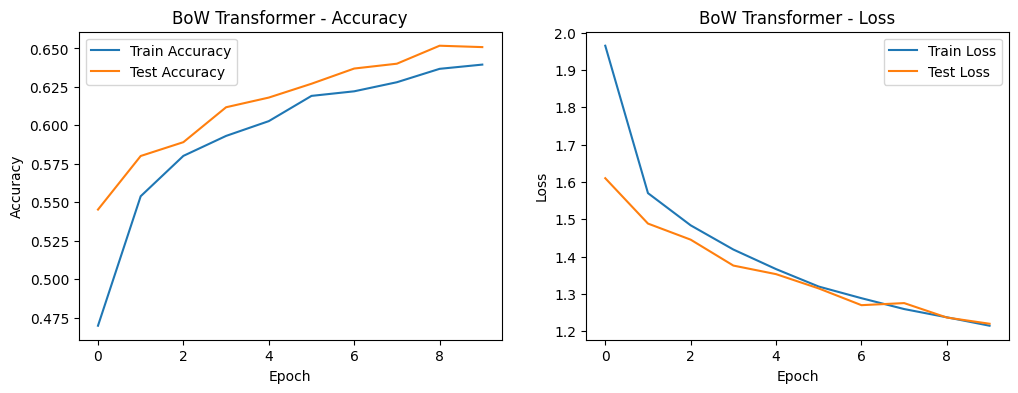

In [76]:
plot_results(history_bow, "BoW Transformer")

In [83]:
evaluate_model(model_bow, X_test_bow, y_test_bow)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       447
           1       1.00      0.33      0.50         3
           2       0.80      0.95      0.87       946
           3       0.93      1.00      0.96       446
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        32
          16       0.66      0.47      0.55       198
          17       0.07      0.20      0.11        49
          18       0.43      0.32      0.37       103
          19       0.34      0.35      0

In [87]:
model_bow.save(f"models/bow_{percent_sample}.keras")

### Ngram

In [77]:
model_ngram = build_transformer_model(vocab_size, n_gram-1)

In [78]:
history_ngram = model_ngram.fit(
    X_train_ng, y_train_ng,
    validation_data=(X_test_ng, y_test_ng),
    epochs=10,
    batch_size=32
)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4240 - loss: 2.1995 - val_accuracy: 0.5496 - val_loss: 1.6273
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5546 - loss: 1.5765 - val_accuracy: 0.5754 - val_loss: 1.5095
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5802 - loss: 1.4822 - val_accuracy: 0.5963 - val_loss: 1.4198
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5941 - loss: 1.4233 - val_accuracy: 0.6020 - val_loss: 1.3812
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6109 - loss: 1.3481 - val_accuracy: 0.6160 - val_loss: 1.3580
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6146 - loss: 1.3233 - val_accuracy: 0.6194 - val_loss: 1.3062
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6221 - loss: 1.2952 - val_accuracy: 0.6247 - val_loss: 1.3091
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6263 - loss: 1.2818 - val_accuracy: 0.

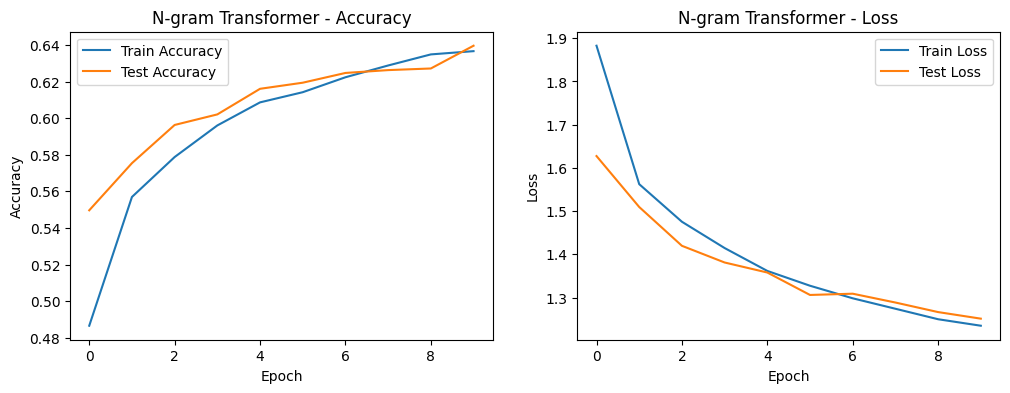

In [79]:
plot_results(history_ngram, 'N-gram Transformer')

In [84]:
evaluate_model(model_ngram, X_test_ng, y_test_ng)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       446
           1       0.00      0.00      0.00         1
           2       0.78      0.93      0.85       923
           3       0.92      1.00      0.96       448
           4       0.50      0.20      0.29         5
           5       0.00      0.00      0.00        13
           6       1.00      0.08      0.14        13
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00        36
          16       0.42      0.45      0.43       177
          17       0.38      0.06      0

In [86]:
model_ngram.save(f"models/ng_{percent_sample}.keras")